In [1]:
from qmt.physics_constants import parse_unit,to_float
from qmt.geometry import part_3d, build_3d_geometry
from qmt.materials import Materials, build_materials, make_materials_library
import pickle, logging
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

Load some 2D shapes from simple_wire.FCStd, and then build some a 3D structure out of them

In [2]:
back_gate = part_3d.ExtrudePart("back_gate", "Sketch", z0=-0.2, thickness=0.1)
vacuum = part_3d.ExtrudePart("vacuum", "Sketch003", z0=-0.5, thickness=1.0)
wire = part_3d.ExtrudePart("wire", "Sketch002", z0=0.0, thickness=0.1)
shell = part_3d.ExtrudePart("shell", "Sketch002", z0=0.1, thickness=0.05)
build_order = [wire, shell, back_gate, vacuum]
file_path = './simple_wire.FCStd'
geo_data = build_3d_geometry(input_parts=build_order, input_file=file_path,
                             xsec_dict={'central':{'axis':(1.,0.,0.),'distance':0.}})
geo_data.write_fcstd('built_geo.fcstd')

'built_geo.fcstd'

At this point you can try opening built_geo.fcstd with FreeCAD and taking a look at the built shape. Feel free to skip this step if you're unfamiliar with the FreeCAD GUI.
We can check that our cross sections and parts are as expected:

In [3]:
geo_data.xsecs

{'central': {'axis': (1.0, 0.0, 0.0),
  'distance': 0.0,
  'polygons': {'wire_0': [[0.0, 0.05, 0.1],
    [0.0, 0.05, 0.0],
    [0.0, -0.05, 0.0],
    [0.0, -0.05, 0.1]],
   'shell_0': [[0.0, 0.05, 0.15000000000000002],
    [0.0, 0.05, 0.1],
    [0.0, -0.05, 0.1],
    [0.0, -0.05, 0.15000000000000002]],
   'back_gate_0': [[0.0, 0.25, -0.1],
    [0.0, 0.25, -0.2],
    [0.0, -0.25, -0.2],
    [0.0, -0.25, -0.1]],
   'vacuum_0': [[0.0, -0.5, 0.5],
    [0.0, 0.5, 0.5],
    [0.0, 0.5, -0.5],
    [0.0, -0.5, -0.5]],
   'vacuum_1': [[0.0, -0.25, -0.1],
    [0.0, 0.25, -0.1],
    [0.0, 0.25, -0.2],
    [0.0, -0.25, -0.2]],
   'vacuum_2': [[0.0, -0.05, 0.0],
    [0.0, 0.05, 0.0],
    [0.0, 0.05, 0.15000000000000002],
    [0.0, -0.05, 0.15000000000000002]]}}}

In [4]:
geo_data.parts

{'wire': <qmt.geometry.part_3d.ExtrudePart at 0x7fe4124f4828>,
 'shell': <qmt.geometry.part_3d.ExtrudePart at 0x7fe4086c2a90>,
 'back_gate': <qmt.geometry.part_3d.ExtrudePart at 0x7fe4086c7438>,
 'vacuum': <qmt.geometry.part_3d.ExtrudePart at 0x7fe4086c7550>}

QMT can't do meshing, so we load a mesh from an example file

In [13]:
from qms.tasks import build_3d_mesh
from qms.meshing import MeshPart
mesh_data = build_3d_mesh(
    geo_data,
    {
        "back_gate": MeshPart(mesh_max_size=0.1),
        "vacuum": MeshPart(mesh_max_size=0.05),
        "wire": MeshPart(mesh_max_size=0.01),
        "shell": MeshPart(mesh_max_size=0.01),
    },
    "comsol"
)

# with open('mesh_data.pkl','rb') as file:
#     mesh_data = pickle.load(file)

tmp/batchlog.txt


Determine the reference level and Al work function to get a 0.1 meV band offset between InSb and Al:

In [7]:
mat_lib = Materials()
Al_WF = mat_lib['Al']['workFunction']
InSb_EA = mat_lib['InSb']['electronAffinity']
InSb_BG = mat_lib['InSb']['directBandGap']
InSb_VBO = mat_lib['InSb']['valenceBandOffset']
Al_WF_level = 0.0-(Al_WF)
InSb_CB_level = 0.0-InSb_EA+InSb_VBO
WF_shift = 200.*parse_unit('meV')-(Al_WF_level-InSb_CB_level)
new_Al_WF = (Al_WF-WF_shift)
ref_level = -new_Al_WF

mat_lib = make_materials_library({"Al":{"workFunction": new_Al_WF}})
mat_data = build_materials(geo_data, 
                           {"back_gate": "Al", "vacuum": "air", "wire": "InSb", "shell": "Al"},
                           mat_lib)

You won't be able to run the simulation with QMT alone. Here we just load the file with simulation results

In [14]:
# with open('tf_data.pkl','rb') as file:
#     tf_data = pickle.load(file)

from qms.tasks.thomas_fermi import ThomasFermiPart
from qms.tasks import run_3d_thomas_fermi
import sympy.physics.units as spu
logging.basicConfig(level=logging.INFO)
tf_data = run_3d_thomas_fermi(geo_data,
                              mesh_data,
                              mat_data,
                              {
                                  "back_gate": ThomasFermiPart("metal_gate", boundary_condition={"voltage": 0.0 * spu.V}),
                                  "vacuum": ThomasFermiPart("dielectric"),
                                  "wire": ThomasFermiPart("semiconductor"),
                                  "shell": ThomasFermiPart("metal_gate", boundary_condition={"voltage": 0.0 * spu.V}),
                              },
                              reference_level=ref_level,
                              volume_charge_integrals=['wire'],order=1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_f64ed8121e7d63248b91edffbb98acf9f46aed17

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00154996 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127    Computing representation of forms
INFO(FFC) lo

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_fca2fd8f19ecf05b5affc038abd76c866a426c93

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_20]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 1
INFO(FFC) log:127    q

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_6552256049aff7d269ac5db4eb7cd2b1ea04257b

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00126839 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_b00be133babf2f543bdf42e792c8fa4deee7235d

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00212073 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling coordinate_mapping ffc_coordinate_mapping_8a3556bbbc7f22c1f4351e32101eb4f75e1cfb36

INFO(FFC) log:127  Compiler stage 1: Analyzing coordinate_mapping(s)
INFO(FFC) log:127  -------------------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00132418 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 0 elements
INFO(FFC) log:127    Computing representation of 0 dofmaps
INFO(FFC) log:127    Computing representation of 1 coordinate mappings
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127    Computing representation of forms
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 2 finished

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_4ea3839cad93700db40b2e4f38e153f0028e58b2

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 4
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_21, f_22]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> defa

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_7a57a1658e9c94c9b92121c187eae9463bb60bd4

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    4
  Coefficients:              '[f_34, f_35, f_36, f_37]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_539816f1669e27b19a17d20c745ffe8d333f527e

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(UFL) log:127  Adjusting missing element cell to tetrahedron.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 4
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    3
  Coefficients:              '[f_34, f_36, f_37]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation: 

calculating charge...
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_eaa806bfed505d91ee351655d54cc3d419142402

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00168967 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127    Computing representation of forms
INFO(FFC) lo

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_3137bda8984cdb2ca79471a997a4cd8e0e0c1f1f

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00146937 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127    Computing representation of forms
INFO(FFC) lo

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_3c6875f740c0c2522a4574e7543718a66dae131d

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'DG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), Vector<3 x CG1(?,?)>, CG1(?,?)'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 2
INFO(FFC) log:127    quadrature_degree: 2
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler sta

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_d8b83c91e0dc1f1308e59cac083198ac56b14d1e

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00129199 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_00e9d0069a2cf12747275f3f04ca476908253d26

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00209332 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_bdde1269bed55f10ac466a1d2b6ec3b14ddc09a0

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00209498 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling coordinate_mapping ffc_coordinate_mapping_5ca3cf5ec44e4b935dadae7f334d52924de2c730

INFO(FFC) log:127  Compiler stage 1: Analyzing coordinate_mapping(s)
INFO(FFC) log:127  -------------------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.00223398 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 0 elements
INFO(FFC) log:127    Computing representation of 0 dofmaps
INFO(FFC) log:127    Computing representation of 1 coordinate mappings
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127    Computing representation of forms
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 2 finished

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_5ecd5492f3fbb31f222e786bf7c48090987fdaeb

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_34, f_63]'
  Unique elements:           'DG1(?,?), CG1(?,?), DG0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), CG1(?,?), DG0(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 4
INFO(FFC) log:127    quadrature_degree: 4
INFO(FFC) log:127 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling element ffc_element_540103cadb5e0111ed79b4015861750e65a2f4e2

INFO(FFC) log:127  Compiler stage 1: Analyzing element(s)
INFO(FFC) log:127  --------------------------------------
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished in 0.0014925 seconds.

INFO(FFC) log:127  Compiler stage 2: Computing intermediate representation
INFO(FFC) log:127  -------------------------------------------------------
INFO(FFC) log:127    Computing representation of 1 elements
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 1 dofmaps
DEBUG(FFC) log:127    Reusing element from cache
INFO(FFC) log:127    Computing representation of 0 coordinate mappings
INFO(FFC) log:127    Computing representation of integrals
INFO(FFC) log:127  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_b7d6c2a9e428e142e3ae33dbd74cfca6379c1824

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 2
INFO(FFC) log:127    quadrature_degree: 2
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finis

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_81a3f93fbaba0667dbc6e4fb153acb4e67cf4007

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_56, f_72]'
  Unique elements:           'CG1(?,?), DG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), DG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 2
INFO(FFC) log:127    quadrature_degree: 2
INFO(FFC) log:127    
INFO(FFC) log:12

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25(FFC) log:127  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO(FFC) log:127  Compiling form ffc_form_667742276a32739678a6e3393c56643f5d40d1cf

INFO(FFC) log:127  Compiler stage 1: Analyzing form(s)
INFO(FFC) log:127  -----------------------------------
DEBUG(FFC) log:127    Preprocessing form using 'uflacs' representation family.
INFO(FFC) log:127    
INFO(FFC) log:127    Geometric dimension:       3
  Number of cell subdomains: 4
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_34]'
  Unique elements:           'CG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO(FFC) log:127    representation:    auto --> uflacs
INFO(FFC) log:127    quadrature_rule:   auto --> default
INFO(FFC) log:127    quadrature_degree: auto --> 3
INFO(FFC) log:127    quadrature_degree: 3
INFO(FFC) log:127    
INFO(FFC) log:127  Compiler stage 1 finished 

First, let's check that all of the boundary conditions are respected:

In [8]:
mesh_data.mesh_id_dict

{'wire': 3, 'shell': 4, 'back_gate': 2, 'vacuum': 1}

Great! Let's take a look at the potential profile to make sure it looks reasonable:

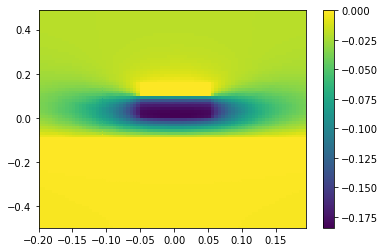

In [15]:
femcoords = tf_data.coordinates
femdata = tf_data.potential
xgrid, ygrid, zgrid = np.mgrid[0:1, -0.2:0.2:0.005, -0.5:0.5:0.0125]
plot_potential = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.pcolor(ygrid[0],zgrid[0],plot_potential[0])
plt.colorbar()
plt.show()

This looks fine. Let's now look at a line cut:

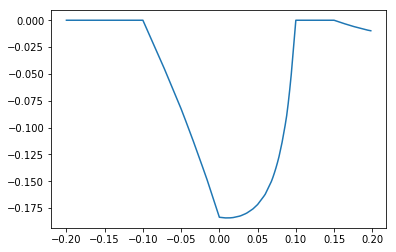

In [13]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, -0.2:0.2:0.002]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

This all looks fine. In the region between 0.0 and 0.1, we have accumulation. Let's make sure this holds up when taking into account the conduction band offset:

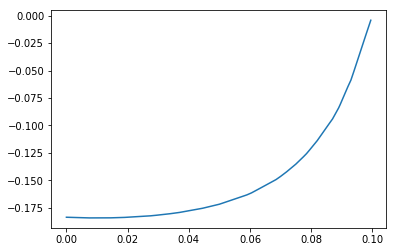

In [14]:
xgrid, ygrid, zgrid = np.mgrid[0:1, 0:1, 0:0.1:0.0005]
potential_cut = griddata(femcoords, femdata, (xgrid, ygrid, zgrid), method='linear')
plt.plot(zgrid[0,0],potential_cut[0,0])
plt.show()

Putting in the proper band offsets, we get:

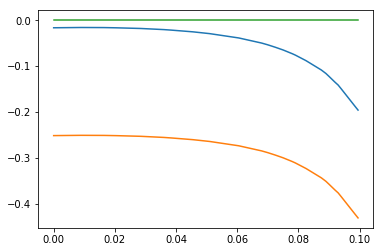

In [15]:
zvec = zgrid[0,0]
potential_cut = potential_cut[0,0]
offset_CB = (InSb_CB_level/parse_unit('meV')-ref_level)/1e3
offset_VB = offset_CB-InSb_BG/parse_unit('meV')/1e3
plt.plot(zvec,offset_CB-potential_cut)
plt.plot(zvec,offset_VB-potential_cut)
plt.plot(zvec,np.zeros(zvec.shape))
plt.show()